In [1]:
import pandas as pd
from pathlib import Path

In [2]:
ruta_base = Path.cwd()
ruta_base = ruta_base.parents[1]

In [6]:
ruta_bd = ruta_base / 'Ejercicio2' / 'data' / 'raw' / 'bd.xlsx'
transacciones_raw = pd.read_excel(ruta_bd, sheet_name='TRANSACCIONES')

In [7]:
transacciones_raw.head()

,IDENTIFICACION,ID_TRANSACCION,FECHA_TRANSACCION,CODIGO_CATEGORIA,ESTADO,VALOR_COMPRA
0,2W3X4Y5Z6A7B8C9D0,5287,2023-01-20 00:00:00,14,Aprobada,150.75
1,2G3H4I5J6K7L8M9N0,1296,2022-12-05 00:00:00,26,Rechazada,200.00
2,2A3B4C5D6E7F8G9H0,4526,2021-06-15 00:00:00,11,Aprobada,75.50
3,2I3J4K5L6M7N8O9P0,9027,2020-09-10 00:00:00,22,Aprobada,300.00
4,2Q3R4S5T6U7V8W9X0,2612,2019-12-25 00:00:00,28,Rechazada,50.00


Analisis exploratorio de datos

In [10]:
transacciones_raw['ID_TRANSACCION'].duplicated().any()


np.True_

<Axes: ylabel='ESTADO'>

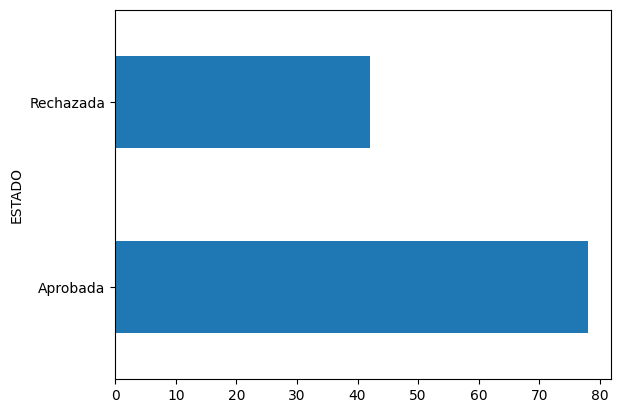

In [11]:
transacciones_raw['ESTADO'].value_counts().plot(kind='barh')


<Axes: >

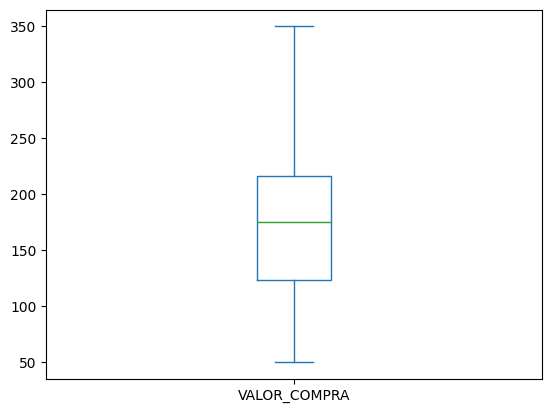

In [12]:
transacciones_raw['VALOR_COMPRA'].plot(kind='box')

Revisamos rangos y valores de fecha

In [14]:
transacciones_raw['FECHA_TRANSACCION'].apply(type).value_counts()


FECHA_TRANSACCION
<class 'datetime.datetime'>    119
<class 'int'>                    1
Name: count, dtype: int64

In [16]:
transacciones_raw[transacciones_raw['FECHA_TRANSACCION'].apply(lambda x: isinstance(x, int))]


,IDENTIFICACION,ID_TRANSACCION,FECHA_TRANSACCION,CODIGO_CATEGORIA,ESTADO,VALOR_COMPRA
34,2A3B4C5D6E7F8G9H0,4260,0,47,Aprobada,205.0


en este caso, lo ideal seria reemplazar el valor actual por el real, bien sea preguntando a quien corresponda en la empresa, como no se puede esta opcion se reemplazara por NaT para indicar que ahi hace falta una fecha valida y que no genere errores despues al consultar informacion

In [17]:
transacciones_raw['FECHA_TRANSACCION'] = transacciones_raw['FECHA_TRANSACCION'].apply(
    lambda x: pd.NaT if x == 0 else x
)
transacciones_raw['FECHA_TRANSACCION'] = pd.to_datetime(transacciones_raw['FECHA_TRANSACCION'], errors='coerce')

In [18]:
fechas = pd.to_datetime(transacciones_raw['FECHA_TRANSACCION'], errors='coerce')
print(fechas.min())
print(fechas.max())


2004-05-10 00:00:00
2023-06-01 00:00:00


In [21]:
ruta_tiempo = ruta_base / 'Ejercicio2' / 'data' / 'raw' / 'Tiempo.xlsx'
tiempo = pd.read_excel(ruta_tiempo)

In [23]:
tiempo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 139 entries, 0 to 138
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   fecha   138 non-null    datetime64[ns]
 1   id      139 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 2.3 KB


In [24]:
transacciones_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120 entries, 0 to 119
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   IDENTIFICACION     120 non-null    object        
 1   ID_TRANSACCION     120 non-null    int64         
 2   FECHA_TRANSACCION  119 non-null    datetime64[ns]
 3   CODIGO_CATEGORIA   120 non-null    int64         
 4   ESTADO             120 non-null    object        
 5   VALOR_COMPRA       120 non-null    float64       
dtypes: datetime64[ns](1), float64(1), int64(2), object(2)
memory usage: 5.8+ KB


Mapeo de id de la dimension Tiempo a la tabla transacciones

In [26]:
transacciones = transacciones_raw.copy()

transacciones = transacciones.merge(tiempo[["fecha", "id"]], left_on="FECHA_TRANSACCION", right_on="fecha", how="left") \
                   .rename(columns={"id": "id_fecha"}) \
                   .drop(columns=["fecha","FECHA_TRANSACCION"]) 

In [27]:
transacciones.head()

,IDENTIFICACION,ID_TRANSACCION,CODIGO_CATEGORIA,ESTADO,VALOR_COMPRA,id_fecha
0,2W3X4Y5Z6A7B8C9D0,5287,14,Aprobada,150.75,133
1,2G3H4I5J6K7L8M9N0,1296,26,Rechazada,200.00,130
2,2A3B4C5D6E7F8G9H0,4526,11,Aprobada,75.50,119
3,2I3J4K5L6M7N8O9P0,9027,22,Aprobada,300.00,113
4,2Q3R4S5T6U7V8W9X0,2612,28,Rechazada,50.00,111


Guardar datos procesados como csv

In [28]:
carpeta_destino = ruta_base / 'Ejercicio2' / 'data' / 'processed'

transacciones.to_csv(carpeta_destino / 'transacciones.csv', index=False)